In [1]:
# ! pip install -U accelerate
# ! pip install -U transformers
# ! pip install datasets peft scikit-learn
# ! pip install transformers[sentencepiece]
# !pip install matplotlib

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
#  Setting the working directory
import os
if os.getcwd() != '/home/rahpon/projects/caste':
    os.chdir('/home/rahpon/projects/caste')
    cwd = os.getcwd()
    
print(cwd)

/home/rahpon/projects/caste


In [3]:
import torch
import logging
import os
import json
import pandas as pd
import numpy as np
from datasets import load_dataset
from datasets import Dataset, DatasetDict
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, TrainingArguments,Trainer
from peft import get_peft_config, get_peft_model,get_peft_model_state_dict, set_peft_model_state_dict, PeftType, PromptEncoderConfig, LoraConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
def classifier(model_path,output_path,lr,epochs):
  logs_dir = os.path.join(output_path,"logs")
  # model_name_or_path = model_path

  tokenizer = AutoTokenizer.from_pretrained(model_path, padding_side= "right") ### will have to be changed depending on model, left forgpt opt bloom
#   if getattr(tokenizer, "pad_token_id") is None:
#       tokenizer.pad_token_id = tokenizer.eos_token_id

  def tokenize_function(examples):
      # max_length=None => use the model max length (it's actually the default)
      outputs = tokenizer(examples["texts"], truncation=True, max_length=250)
      return outputs

  train_pd = pd.read_csv(r'DataSplit/train.csv')
  val_pd = pd.read_csv(r'DataSplit/val.csv')

  #Converting the pandas dataframe to HuggingFace DatasetDict format:
  train_ds = Dataset.from_pandas(train_pd)
  val_ds = Dataset.from_pandas(val_pd)

  data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")
  tokenized_train = train_ds.map(tokenize_function, batched = True)
  tokenized_val = val_ds.map(tokenize_function, batched = True)
  tokenized_train = tokenized_train.rename_column("label", "labels")
  tokenized_val = tokenized_val.rename_column("label", "labels")

  
  # peft_config = PromptEncoderConfig(task_type="SEQ_CLS", num_virtual_tokens=20, encoder_hidden_size=128)
  # peft_config = LoraConfig(task_type="SEQ_CLS", num_virtual_tokens=20, encoder_hidden_size=128)
  model = AutoModelForSequenceClassification.from_pretrained(model_path, return_dict=True)  #
  # print(model)
  # def print_module_names(model):
  #     for name, module in model.named_modules():
  #         print(name)
  # print_module_names(model)
############### 
  # model = AutoModelForSequenceClassification.from_pretrained(base_model, id2label=id2label)

  peft_config = LoraConfig(task_type="SEQ_CLS", inference_mode=False, r=8, lora_alpha=16, lora_dropout=0.1,target_modules=["query","value"])
  # peft_model = get_peft_model(model, peft_config)

  # print('PEFT Model')
  # peft_model.print_trainable_parameters()

  # peft_lora_finetuning_trainer = get_trainer(peft_model)

  # peft_lora_finetuning_trainer.train()
  # peft_lora_finetuning_trainer.evaluate()

#############

  model.set_default_language("ta_IN")
  model = get_peft_model(model, peft_config)
  model.print_trainable_parameters()

  def compute_metrics(eval_pred):
      preds, labels = eval_pred
      preds = np.argmax(preds, axis=1)
      accuracy = accuracy_score(labels, preds)
      precision = precision_score(labels, preds, average='weighted')
      recall = recall_score(labels, preds, average='weighted')
      f1 = f1_score(labels, preds, average='weighted')
      return {
          'accuracy': accuracy,
          'precision': precision,
          'recall': recall,
          'f1': f1
      }

  training_args = TrainingArguments(
    output_dir=output_path,
    learning_rate=lr,
    per_device_train_batch_size= 16,
    per_device_eval_batch_size= 16,
    num_train_epochs=epochs,
    weight_decay=0.01,
    eval_strategy="steps",  # Evaluate at specified steps
    save_strategy="steps",
    eval_steps= 50,
    save_steps = 1500,
    logging_steps=50,
    load_best_model_at_end=True,
    logging_dir=logs_dir, #tensorboard
    # save_total_limit=5,
    #report_to = "wandb"
  )

  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=tokenized_train,
      eval_dataset = tokenized_val,
      tokenizer=tokenizer,
      data_collator=data_collator,
      compute_metrics = compute_metrics
  )
  # print("Done.....")
  train_result = trainer.train()

  # compute train results
  metrics = train_result.metrics
  max_train_samples = len(tokenized_train)
  metrics["train_samples"] = min(max_train_samples, len(tokenized_train))

  # save train results
  trainer.log_metrics("train", metrics)
  trainer.save_metrics("train", metrics)

  model.save_pretrained(training_args.output_dir)

  losses= trainer.state.log_history
  #print("trainer.state.log_history: ")
  #print(losses)
  training_loss_path = os.path.join(output_path,"training_loss.json")
  eval_loss_path = os.path.join(output_path, "eval_loss.json")
  training_losses = [entry for entry in losses if 'loss' in entry]
  eval_losses = [entry for entry in losses if 'eval_loss' in entry]
  with open(training_loss_path, 'w') as f:
      json.dump(training_losses, f, indent=2)
  with open(eval_loss_path, 'w') as f:
      json.dump(eval_losses, f, indent=2)



In [5]:
import warnings
warnings.filterwarnings("ignore")

#######################################
lr = 3e-5
EPOCHS = 20
root = os.path.join("saved_models/peft",str(lr))
sub_dir ="xmod-base"
output_path = os.path.join(root,sub_dir)
model_path = 'facebook/xmod-base'
########################################
classifier(model_path,output_path,lr,EPOCHS)



Map:   0%|          | 0/5040 [00:00<?, ? examples/s]

Map:   0%|          | 0/1260 [00:00<?, ? examples/s]

Some weights of XmodForSequenceClassification were not initialized from the model checkpoint at facebook/xmod-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 887,042 || all params: 853,360,900 || trainable%: 0.1039


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [7]:
"""Predictions"""

import torch
import pandas as pd
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import confusion_matrix, classification_report

peft_model_id = output_path
config = PeftConfig.from_pretrained(peft_model_id)
inference_model = AutoModelForSequenceClassification.from_pretrained(config.base_model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
model = PeftModel.from_pretrained(inference_model, peft_model_id)
model.set_default_language("ta_IN")

test_data_path = r"DataSplit/test.csv"
test_data = pd.read_csv(test_data_path)
test_texts = test_data['texts'].tolist()

predictions_df = test_texts

tokenized_test = tokenizer(test_texts, truncation=True, padding=True, return_tensors='pt',max_length = 250)

with torch.no_grad():
  outputs = model(**tokenized_test)

logits = outputs.logits
probs = torch.nn.functional.softmax(logits, dim=-1)
predicted_labels = torch.argmax(probs, dim=-1).tolist()

predictions_df = test_data

predictions_df['predictions'] = predicted_labels

labels = test_data['labels'].tolist()

conf_matrix = confusion_matrix(predictions_df['labels'], predictions_df['predictions'])

print(conf_matrix)

class_report = classification_report(labels, predicted_labels)

print(class_report)

predictions_path = os.path.join(output_path,'predictions.csv')

predictions_df.to_csv(predictions_path)

metrics_path = os.path.join(output_path,"metrics.txt")

with open(metrics_path,'a') as f:
  f.write("PEFT")
  f.write("learning rate: ")
  f.write(str(lr))
  f.write(model_path)
  f.write("\n")
  f.write(class_report)
  f.write("Confusion Matric:\n")
  np.savetxt(f,conf_matrix,fmt = "%d")

Some weights of XmodForSequenceClassification were not initialized from the model checkpoint at facebook/xmod-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[[780 193]
 [335 267]]
              precision    recall  f1-score   support

           0       0.70      0.80      0.75       973
           1       0.58      0.44      0.50       602

    accuracy                           0.66      1575
   macro avg       0.64      0.62      0.62      1575
weighted avg       0.65      0.66      0.65      1575



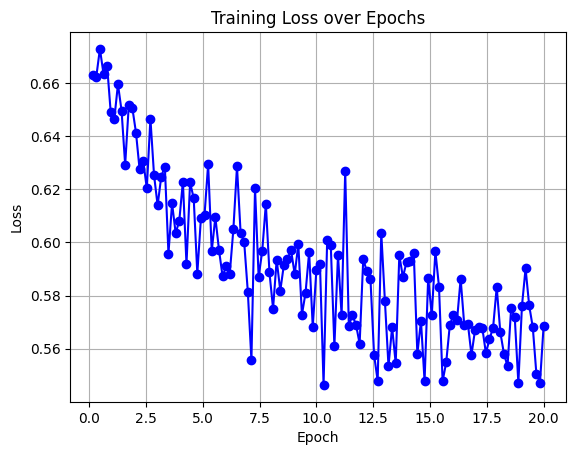

In [8]:
"""Saving Loss plots"""

import matplotlib.pyplot as plt
import json
import os
train_loss_path = os.path.join(output_path,"training_loss.json")

# Load the JSON file
with open(train_loss_path, 'r') as file:
    data = json.load(file)

# Extracting values for plotting
epochs = [entry['epoch'] for entry in data]
losses = [entry['loss'] for entry in data]

# Plotting the training losses over epochs
plt.plot(epochs, losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)


loss_plot_path = os.path.join(output_path,'training_loss_plot.png')
plt.savefig(loss_plot_path)

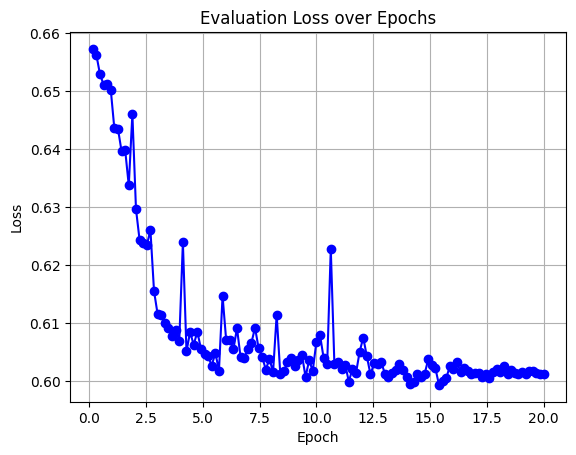

In [9]:
"""Saving Loss plots"""

import matplotlib.pyplot as plt
import json
import os
train_loss_path = os.path.join(output_path,"eval_loss.json")

# Load the JSON file
with open(train_loss_path, 'r') as file:
    data = json.load(file)

# Extracting values for plotting
epochs = [entry['epoch'] for entry in data]
losses = [entry['eval_loss'] for entry in data]

# Plotting the training losses over epochs
plt.plot(epochs, losses, marker='o', linestyle='-', color='b')
plt.title('Evaluation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)


loss_plot_path = os.path.join(output_path,'eval_loss_plot.png')
plt.savefig(loss_plot_path)